<a href="https://colab.research.google.com/github/baasitsharief/Dual_Branch_allotment/blob/master/JPMCQuant_ML_Baasit_BITS_Hyderabad_F2016AAPS0209H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats import norm
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import matplotlib.pyplot as plt

testing_data_file = "https://mettl-arq.s3-ap-southeast-1.amazonaws.com/questions/jp-morgan/housing/housing_test.csv"
testing_data = pd.read_csv(testing_data_file)

In [2]:
testing_data.head()

,TID,Date,Property Type,OldvNew,Duration,AddressLine1,AddressLine2,Street,Locality,Town,Taluka,District,Postcode,Price Category
0,1226697,2019-04-01,F,N,L,UXCEBQ SYWKM,56,ZYHWKL KYUF,ZYHWKL XULFX,NREMYL GBQLBX,SBLMKUE HBFVYKFXORKB,SBLMKUE HBFVYKFXORKB,NG09 2CU,A
1,1226784,2019-04-01,S,N,F,XOYMVYKF,0,XBEXBQ KYUF,XRFEBXOUN,SORSOBXMBK,SORSOBXMBK,ZBXM XWXXBA,CY57 9KF,A
2,1226816,2019-04-01,F,N,L,"JKUSBZBEE SYWKM, 0457",UCUKMNBLM 56,XMKUMVYKF KYUF,OUEE JKBBL,HRKNRLJOUN,HRKNRLJOUN,ZBXM NRFEULFX,H52 8BM,A
3,1226838,2019-04-01,F,Y,L,MOB SOYSYEUMB DWUKMBK,51 KRPBK OYWXB,MKUTBSMWX ZUQ,GBQLXOUN,HKRXMYE,HUMO ULF LYKMO BUXM XYNBKXBM,HUMO ULF LYKMO BUXM XYNBKXBM,HX60 5JJ,A
4,1226845,2019-04-01,F,N,L,NUGBCBUSB NULXRYLX,VEUM 500,NUGBCBUSB UPBLWB,ORJOJUMB,EYLFYL,SUNFBL,JKBUMBK EYLFYL,L3 3BM,A


In [0]:
training_data_file = "https://mettl-arq.s3-ap-southeast-1.amazonaws.com/questions/jp-morgan/housing/housing_train.csv"
train_orig = pd.read_csv(training_data_file)

In [4]:
train_orig.head()

,TID,Date,Property Type,OldvNew,Duration,AddressLine1,AddressLine2,Street,Locality,Town,Taluka,District,Postcode,Price,Price Category
0,1000,2018-01-01,F,N,L,9,NaN,XOUGBXCBUKB NBZX,NaN,ERLSYEL,ERLSYEL,ERLSYELXORKB,EL4 2BO,80.0,B
1,1001,2018-01-01,T,Y,F,02,NaN,OYYG ZUQ,NaN,NURFXMYLB,NURFXMYLB,GBLM,NB09 6VZ,218.5,A
2,1002,2018-01-01,D,N,F,32,NaN,XYNBKX CUKG UPBLWB,NaN,NUEPBKL,NUEPBKL OREEX,ZYKSBXMBKXORKB,ZK01 0XF,250.0,A
3,1003,2018-01-01,O,N,F,0,NaN,OUMOUZUQ SEYXB,NaN,EBRSBXMBK,EBRSBXMBK,EBRSBXMBK,EB1 3HI,6050.0,B
4,1004,2018-01-01,T,N,F,14,NaN,MBNBKURKB KYUF,NaN,CEQNYWMO,SRMQ YV CEQNYWMO,SRMQ YV CEQNYWMO,CE4 6WU,182.0,A


# Visualizing the training dataset and cleaning the Dateset


 mu = 349.76 and sigma = 1829.58



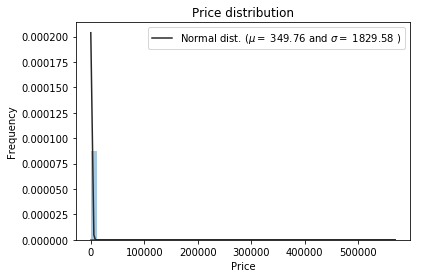

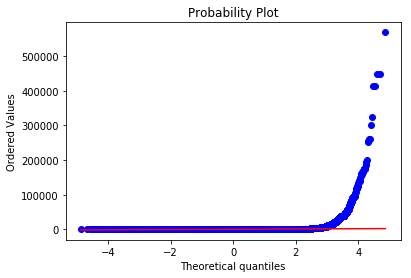

Skewness: 114.925001
Kurtosis: 22639.451053


In [5]:
import seaborn as sns

sns.distplot(train_orig['Price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_orig['Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(train_orig['Price'], plot=plt)
plt.show()

print("Skewness: %f" % train_orig['Price'].skew())
print("Kurtosis: %f" % train_orig['Price'].kurt())

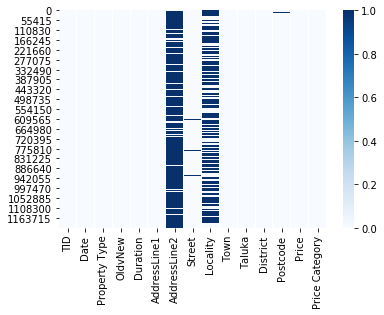

In [6]:
sns.heatmap(train_orig.isnull(), cmap = 'Blues')

Since transaction ID doesn't really matter in price of houses, also Address line 2 and Locality has a lot of null elements so I dropped it off.

In [7]:
train = train_orig.drop(['AddressLine2','Locality', 'TID'], axis = 1)
train.head()

,Date,Property Type,OldvNew,Duration,AddressLine1,Street,Town,Taluka,District,Postcode,Price,Price Category
0,2018-01-01,F,N,L,9,XOUGBXCBUKB NBZX,ERLSYEL,ERLSYEL,ERLSYELXORKB,EL4 2BO,80.0,B
1,2018-01-01,T,Y,F,02,OYYG ZUQ,NURFXMYLB,NURFXMYLB,GBLM,NB09 6VZ,218.5,A
2,2018-01-01,D,N,F,32,XYNBKX CUKG UPBLWB,NUEPBKL,NUEPBKL OREEX,ZYKSBXMBKXORKB,ZK01 0XF,250.0,A
3,2018-01-01,O,N,F,0,OUMOUZUQ SEYXB,EBRSBXMBK,EBRSBXMBK,EBRSBXMBK,EB1 3HI,6050.0,B
4,2018-01-01,T,N,F,14,MBNBKURKB KYUF,CEQNYWMO,SRMQ YV CEQNYWMO,SRMQ YV CEQNYWMO,CE4 6WU,182.0,A


In [8]:
train.shape

(1219110, 12)

In [0]:
date = train[ 'Date'].values

In [10]:
date

array(['2018-01-01', '2018-01-01', '2018-01-01', ..., '2019-03-31',
       '2019-03-31', '2019-03-31'], dtype=object)

In [0]:
sObject = slice(0,4)
year = []
for dates in date:
  year.append(dates[sObject])

Since, inflation might increase the price over time, so just taking the year into account instead of date

In [0]:
#year

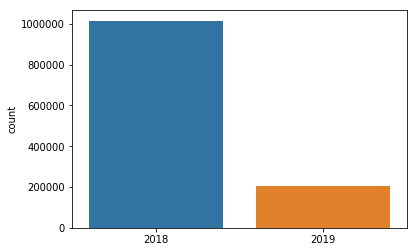

In [13]:
sns.countplot(year, label = 'Counts')

In [0]:
train = train.drop(['Date'], axis = 1)

In [15]:
train.head()

,Property Type,OldvNew,Duration,AddressLine1,Street,Town,Taluka,District,Postcode,Price,Price Category
0,F,N,L,9,XOUGBXCBUKB NBZX,ERLSYEL,ERLSYEL,ERLSYELXORKB,EL4 2BO,80.0,B
1,T,Y,F,02,OYYG ZUQ,NURFXMYLB,NURFXMYLB,GBLM,NB09 6VZ,218.5,A
2,D,N,F,32,XYNBKX CUKG UPBLWB,NUEPBKL,NUEPBKL OREEX,ZYKSBXMBKXORKB,ZK01 0XF,250.0,A
3,O,N,F,0,OUMOUZUQ SEYXB,EBRSBXMBK,EBRSBXMBK,EBRSBXMBK,EB1 3HI,6050.0,B
4,T,N,F,14,MBNBKURKB KYUF,CEQNYWMO,SRMQ YV CEQNYWMO,SRMQ YV CEQNYWMO,CE4 6WU,182.0,A


In [16]:
year_df = pd.DataFrame(data = {"Year":year})
year_df.head()

,Year
0,2018
1,2018
2,2018
3,2018
4,2018


In [17]:
train = pd.concat([train,year_df], axis = 1)
train.head()

,Property Type,OldvNew,Duration,AddressLine1,Street,Town,Taluka,District,Postcode,Price,Price Category,Year
0,F,N,L,9,XOUGBXCBUKB NBZX,ERLSYEL,ERLSYEL,ERLSYELXORKB,EL4 2BO,80.0,B,2018
1,T,Y,F,02,OYYG ZUQ,NURFXMYLB,NURFXMYLB,GBLM,NB09 6VZ,218.5,A,2018
2,D,N,F,32,XYNBKX CUKG UPBLWB,NUEPBKL,NUEPBKL OREEX,ZYKSBXMBKXORKB,ZK01 0XF,250.0,A,2018
3,O,N,F,0,OUMOUZUQ SEYXB,EBRSBXMBK,EBRSBXMBK,EBRSBXMBK,EB1 3HI,6050.0,B,2018
4,T,N,F,14,MBNBKURKB KYUF,CEQNYWMO,SRMQ YV CEQNYWMO,SRMQ YV CEQNYWMO,CE4 6WU,182.0,A,2018


Data exploration to fill the null entries in the postcodes

In [18]:
train['Street'].describe()

count         1196498
unique         192843
top       ORJO XMKBBM
freq             9027
Name: Street, dtype: object

In [19]:
train['Postcode'].describe()

count     1213332
unique     598399
top        E4 6UU
freq          275
Name: Postcode, dtype: object

In [20]:
train[(train['Price']<=94) & (train['Price']>=93.5)]['Postcode'].describe()

count        1591
unique       1527
top       E07 0EF
freq           11
Name: Postcode, dtype: object

In [21]:
train_orig[train_orig["Postcode"].isnull()]['Price'].median()

93.9815

In [0]:
def FillPC(postcode):
  if(pd.isnull(postcode)):
    return 'E07 0EF'
  else:
    return postcode

In [0]:
train["Postcode"] = train["Postcode"].apply(FillPC)

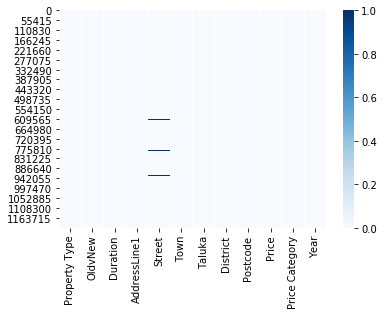

In [24]:
sns.heatmap(train.isnull(), cmap = 'Blues')

In [0]:
nulls = train[train['Street'].isnull()]

In [26]:
nulls.head()

,Property Type,OldvNew,Duration,AddressLine1,Street,Town,Taluka,District,Postcode,Price,Price Category,Year
74,O,N,F,GRLJ'X PUEB,NaN,GBMMBKRLJ,GBMMBKRLJ,LYKMOUNCMYLXORKB,E07 0EF,11.455,B,2018
75,O,N,F,GRLJ'X PUEB,NaN,GBMMBKRLJ,GBMMBKRLJ,LYKMOUNCMYLXORKB,E07 0EF,11.818,B,2018
80,O,N,F,GRLJ'X PUEB,NaN,GBMMBKRLJ,GBMMBKRLJ,LYKMOUNCMYLXORKB,E07 0EF,10.909,B,2018
85,O,N,F,GRLJ'X PUEB,NaN,GBMMBKRLJ,GBMMBKRLJ,LYKMOUNCMYLXORKB,E07 0EF,11.818,B,2018
86,O,N,F,GRLJ'X PUEB,NaN,GBMMBKRLJ,GBMMBKRLJ,LYKMOUNCMYLXORKB,E07 0EF,32.727,B,2018


In [27]:
train[(train['Street'].isnull())&(train['Town']=='GBMMBKRLJ')].head()

,Property Type,OldvNew,Duration,AddressLine1,Street,Town,Taluka,District,Postcode,Price,Price Category,Year
74,O,N,F,GRLJ'X PUEB,NaN,GBMMBKRLJ,GBMMBKRLJ,LYKMOUNCMYLXORKB,E07 0EF,11.455,B,2018
75,O,N,F,GRLJ'X PUEB,NaN,GBMMBKRLJ,GBMMBKRLJ,LYKMOUNCMYLXORKB,E07 0EF,11.818,B,2018
80,O,N,F,GRLJ'X PUEB,NaN,GBMMBKRLJ,GBMMBKRLJ,LYKMOUNCMYLXORKB,E07 0EF,10.909,B,2018
85,O,N,F,GRLJ'X PUEB,NaN,GBMMBKRLJ,GBMMBKRLJ,LYKMOUNCMYLXORKB,E07 0EF,11.818,B,2018
86,O,N,F,GRLJ'X PUEB,NaN,GBMMBKRLJ,GBMMBKRLJ,LYKMOUNCMYLXORKB,E07 0EF,32.727,B,2018


In [28]:
train[train["Street"]=='ORJO XMKBBM'].head()

,Property Type,OldvNew,Duration,AddressLine1,Street,Town,Taluka,District,Postcode,Price,Price Category,Year
117,O,N,F,2,ORJO XMKBBM,CYKMO,KOYLFFU SQLYL MUVV,KOYLFFU SQLYL MUVV,SV68 2CJ,100.00,B,2018
713,D,N,F,"MOB YEF HWMSOBKX XOYC, 56H",ORJO XMKBBM,NUKGBM OUKHYKYWJO,OUKHYKYWJO,EBRSBXMBKXORKB,EB03 2WF,176.45,A,2018
856,T,N,F,XBUPRBZ,ORJO XMKBBM,SORSOBXMBK,SORSOBXMBK,ZBXM XWXXBA,CY02 2EK,1075.00,A,2018
1138,T,N,F,67,ORJO XMKBBM,CYLMQSEWL,KOYLFFU SQLYL MUVV,KOYLFFU SQLYL MUVV,SV95 2HK,89.00,A,2018
1217,F,N,L,"BEQ OYWXB, 59",ORJO XMKBBM,UFFEBXMYLB,KWLLQNBFB,XWKKBQ,GM04 0MM,290.00,A,2018


Street is not a good factor determining the price because for the same street there are different postcodes and prices.

In [0]:
train = train.drop(['Street'], axis = 1)

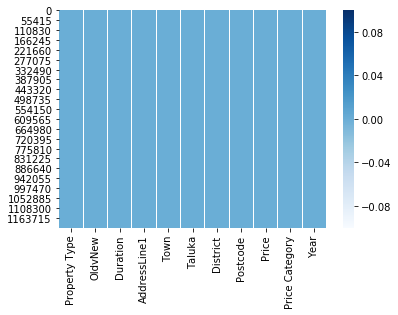

In [30]:
sns.heatmap(train.isnull(), cmap = 'Blues')

In [31]:
train['Town'].describe()

count     1219110
unique       1147
top        EYLFYL
freq        77887
Name: Town, dtype: object

In [32]:
train['Taluka'].describe()

count        1219110
unique           353
top       HRKNRLJOUN
freq           19391
Name: Taluka, dtype: object

In [33]:
train['Postcode'].describe()

count     1219110
unique     598399
top       E07 0EF
freq         5813
Name: Postcode, dtype: object

In [34]:
X = train.drop(['Price'], axis = 1)
Y = train['Price']

cols = X.columns.tolist()
print(cols)
print(train["Price"])

['Property Type', 'OldvNew', 'Duration', 'AddressLine1', 'Town', 'Taluka', 'District', 'Postcode', 'Price Category', 'Year']
0            80.000
1           218.500
2           250.000
3          6050.000
4           182.000
5            30.000
6           130.000
7           107.000
8            71.000
9           153.750
10          215.000
11          390.000
12          167.590
13          233.500
14          270.000
15         3178.209
16          395.000
17          220.000
18          349.000
19          470.000
20          273.000
21          112.000
22          410.000
23          170.000
24          335.000
25          405.000
26          186.000
27          172.500
28          265.000
29          400.000
             ...   
1219080     182.000
1219081    2282.256
1219082    2591.407
1219083     130.000
1219084     658.937
1219085     399.922
1219086     130.000
1219087     324.140
1219088     595.709
1219089    5000.000
1219090    1705.625
1219091     322.744
1219092     418

Label Encoding all the remaining features

In [35]:
from sklearn.preprocessing import LabelEncoder

for c in cols:
  l_enc = LabelEncoder()
  l_enc.fit(list(X[c].values)) 
  X[c] = l_enc.transform(list(X[c].values))
X.head()

,Property Type,OldvNew,Duration,AddressLine1,Town,Taluka,District,Postcode,Price Category,Year
0,1,0,1,5615,144,31,9,78508,1,0
1,4,1,0,614,602,174,17,346612,0,0
2,0,0,0,2810,582,171,112,572077,0,0
3,2,0,0,19,91,28,7,62842,1,0
4,4,0,0,2065,47,224,72,31006,0,0



 mu = 5.45 and sigma = 0.74



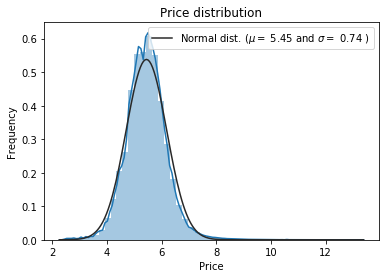

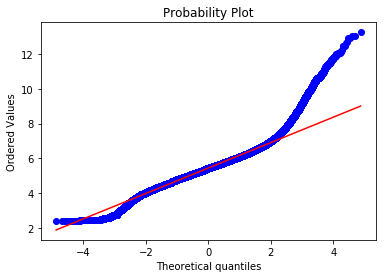

Skewness: 0.510492
Kurtosis: 3.280740


In [36]:
import numpy as np
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_n = train
train_n["Price"] = np.log1p(train["Price"])

#Check the new distribution 
sns.distplot(train_n['Price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_n['Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(train_n['Price'], plot=plt)
plt.show()

Y = train_n['Price'].values

print("Skewness: %f" % train_n['Price'].skew())
print("Kurtosis: %f" % train_n['Price'].kurt())

In [37]:
print(Y)
print(np.expm1(Y))

[4.39444915 5.39135223 5.52545294 ... 6.34873681 6.48155263 6.06898099]
[ 80.    218.5   250.    ... 570.77  651.984 431.24 ]


We can see that skewness and Kurtosis has improved drastically.

# Model Selection and Training

In [0]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

Creating a Training, Validation and a test set

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X.values, Y, test_size = 0.15, random_state = 2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.17, random_state = 2)

Trying on two different Regression Models - 1. Random Forest, 2. Lasso 

In [40]:
rfr_model = RandomForestRegressor()
rfr_model.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [41]:
Y_pred = rfr_model.predict(X_val)

print(Y_pred)

[5.01874946 5.11712569 6.54076336 ... 4.10359194 5.81275583 5.53090742]


In [0]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Y_val, Y_pred)

In [43]:
mse

0.1885097131123397

In [44]:
lasso = make_pipeline(RobustScaler(),Lasso())
lasso.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [45]:
Y_pred_l = lasso.predict(X_val)
mse_l = mean_squared_error(Y_val, Y_pred_l)
print(mse_l)

0.5511464333894976


As we can see Random Forest Regression gives us a smaller error, so I'll try adjusting the hyparameters to see if I can better results

In [46]:
rfr_model = RandomForestRegressor(n_estimators = 20)
rfr_model.fit(X_train, Y_train)
Y_pred = rfr_model.predict(X_val)
mse = mean_squared_error(Y_val, Y_pred)
print(mse)

0.1818801537637879


In [47]:
rfr_model = RandomForestRegressor(n_estimators = 25)
rfr_model.fit(X_train, Y_train)
Y_pred = rfr_model.predict(X_val)
mse = mean_squared_error(Y_val, Y_pred)
print(mse)

0.1801702400774683


In [48]:
Y_test_pred = rfr_model.predict(X_test)
mse_t = mean_squared_error(Y_test, Y_test_pred)
print(mse_t)

0.17797955071796198


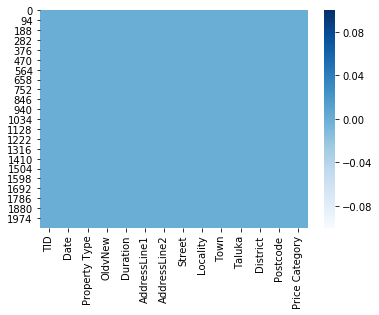

In [49]:
test = testing_data
sns.heatmap(test.isnull(), cmap = 'Blues')

In [50]:
test = test.drop(['AddressLine2','Locality', 'TID'], axis = 1)
dates = test['Date'].values
year_t = []
for d in dates:
  year_t.append(d[sObject])
print(year_t)

['2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019', '2019',

In [51]:
test_year_df = pd.DataFrame(data = {"Year":year_t})
test_year_df.head()

,Year
0,2019
1,2019
2,2019
3,2019
4,2019


In [0]:
test = test.drop(['Date'], axis = 1)

In [0]:
test = pd.concat([test,test_year_df], axis = 1)

In [54]:
test.head()

,Property Type,OldvNew,Duration,AddressLine1,Street,Town,Taluka,District,Postcode,Price Category,Year
0,F,N,L,UXCEBQ SYWKM,ZYHWKL KYUF,NREMYL GBQLBX,SBLMKUE HBFVYKFXORKB,SBLMKUE HBFVYKFXORKB,NG09 2CU,A,2019
1,S,N,F,XOYMVYKF,XBEXBQ KYUF,SORSOBXMBK,SORSOBXMBK,ZBXM XWXXBA,CY57 9KF,A,2019
2,F,N,L,"JKUSBZBEE SYWKM, 0457",XMKUMVYKF KYUF,HRKNRLJOUN,HRKNRLJOUN,ZBXM NRFEULFX,H52 8BM,A,2019
3,F,Y,L,MOB SOYSYEUMB DWUKMBK,MKUTBSMWX ZUQ,HKRXMYE,HUMO ULF LYKMO BUXM XYNBKXBM,HUMO ULF LYKMO BUXM XYNBKXBM,HX60 5JJ,A,2019
4,F,N,L,NUGBCBUSB NULXRYLX,NUGBCBUSB UPBLWB,EYLFYL,SUNFBL,JKBUMBK EYLFYL,L3 3BM,A,2019


In [55]:
test = test.drop(["Street"], axis = 1)
cols = test.columns.tolist()
for c in cols:
  l_enc = LabelEncoder()
  l_enc.fit(list(test[c].values)) 
  test[c] = l_enc.transform(list(test[c].values))

test['Year'] = 1 
test.head()

,Property Type,OldvNew,Duration,AddressLine1,Town,Taluka,District,Postcode,Price Category,Year
0,1,0,1,1197,194,176,60,1136,0,1
1,3,0,0,1351,273,186,95,167,0,1
2,1,0,1,528,97,60,93,439,0,1
3,1,1,1,715,87,66,22,716,0,1
4,1,0,1,845,44,202,26,855,0,1


In [0]:
Y_test_final = rfr_model.predict(test)

In [57]:
Y_test_final

array([4.51751406, 5.42900448, 5.05946093, ..., 6.44336175, 5.72411607,
       5.72411607])

In [0]:
Y_test_final = np.expm1(Y_test_final)

In [59]:
Y_test_final

array([ 90.60758332, 226.9222319 , 156.50558657, ..., 627.5161674 ,
       305.16252013, 305.16252013])

In [0]:
Price_df = pd.DataFrame(data = {'Price Predicted' : Y_test_final})
Price_df.to_csv("Submission.csv")

Downloaded the submission file and then hosted on a file hosting server to pull the outputs in the code

In [0]:
csv_test = "https://sendeyo.com/up/d/88b21414cd"
df_test = pd.read_csv(csv_test)